# Project 3: Binary Classification

*Project Outline:*

- [Dataset Analysis](#analyze)
- [Prepare Data](#prepare)
- [Regression Model](#regression)
- [Boosting Model](#boost)
- [Variable Importance](#variable)
- [Model Comparison](#compare)

In [62]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, det_curve, confusion_matrix, \
        plot_det_curve, plot_roc_curve, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from math import log, sqrt
%matplotlib inline 

In [3]:
# Suppress regression convergence warnings
import warnings
warnings.filterwarnings('ignore')

<a id="analyze"></a>
## Dataset Analysis
We will evaluate the shape, size and profile of the credit card transaction set to determine our approach to data preparation for model training.

In [4]:
df = pd.read_csv('creditcard.csv')
print(df.shape)
df.head(1)

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0


In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
# Sample dataframe for faster training
df = df.sample(frac=0.1)

#### *Analysis*

*Balance*

We can see by the small number of fraud cases in the dataset that the data is highly skewed (unbalanced). We can test whether the model will perform better with a more balanced dataset by oversampling the positive (fraudulent) values, and comparing that to the results with the original model.

*Cross-Validation*

Cross-validation is an effective strategy to improve the performance of a model when available data is limited. In this case, we have nearly 300k datapoints, and while only a small number of those are fraudulent, it is plenty of data to train the model and cross-validation is likely not necessary. That being said, we will test the results using a cross-validated model to see if performance improves.

<a id="prepare"></a>
## Dataset Preparation
We will prepare training and testing datasets using the original distribution, and an alternative training set using an oversampling approach to balance the data to compare performance results.

In [52]:
# Splitting of original population
X = df.values[:,:-1]
y = df.values[:,-1].reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"""Full data: {(y == 1).sum() / y.shape[0]:.3%} 
Training: {(y_train == 1).sum() / y_train.shape[0]:.3%} 
Testing: {(y_test == 1).sum() / y_test.shape[0]:.3%}""")

Full data: 0.151% 
Training: 0.149% 
Testing: 0.158%


In [53]:
# Oversampling approach (~5%) of the training set
df_o = pd.DataFrame(np.concatenate([X_train, y_train], axis=1), columns=df.columns)
df0 = df_o.query('Class == 0')
df1 = df_o.query('Class == 1')

# Append fraud entries until 5% of population
df_o = df0.copy()
while True:
    df_o = pd.concat([df_o, df1], ignore_index=True)
    if df_o.Class.value_counts()[1] / df_o.shape[0] > 0.05:
        break
X_o_train = df_o.values[:,:-1]
y_o_train = df_o.values[:,-1]
print(df_o.shape)
print(f'{df_o.Class.value_counts()[1] / df_o.shape[0]:.2%}')
df_o.Class.value_counts()

(23974, 31)
5.11%


0.0    22750
1.0     1224
Name: Class, dtype: int64

In [54]:
# Use standard scaler to normalize

# Original Data
scaler = StandardScaler()
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

# Oversampled Data
scaler = StandardScaler()
scaler.fit(X_o_train)

X_o_train_norm = scaler.transform(X_o_train)

In [55]:
# Convert vectors back to 1d array
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

<a id="regression"></a>
## Regression Modeling
Because our data is highly unbalanced, an accuracy metric will not be an effective measure of model success. To account for the small amount of positives (fraud) in the dataset, we will use f1 score to evaluate the model, which considers a combination of recall (true positives identified) and precision (accurate predictions of fraud). This heightens focus on the small population of fraudulent entries but balances the tendency to overpredict fraud. 

I will train 4 penalized regression models and compare the results:
- Vanilla Logistic regression (no CV) with original distribution
- 5-Fold Cross-Validated Logistic Regression with original distribution
- Vanilla Logistic regression (no CV) with oversampled distribution
- 5-Fold Cross-Validated Logistic Regression with oversampled distribution

In [56]:
# Establish scoring metrics and list to store results
metric = 'f1' # Weighted average of precision and recall
model_results = []

In [57]:
# Fit the model with plain logistic regression (no cross-validation)
clf = LogisticRegressionCV(cv=None, penalty='elasticnet',  l1_ratios=[0.1, 0.5, 1.0],
                           solver='saga',
                           scoring=metric,
                           random_state=42)
clf.fit(X_train_norm, y_train)
model_results.append((clf.score(X_train_norm, y_train), clf.score(X_test_norm, y_test)))

# Metric scoring
print(metric+' with vanilla logistic regression, original distribution:')
print('Training: ', clf.score(X_train_norm, y_train))
print('Testing: ', clf.score(X_test_norm, y_test))

f1 with vanilla logistic regression, original distribution:
Training:  0.7741935483870968
Testing:  0.7142857142857143


In [58]:
# Fit the model with 5 cross-validation iterations
clf1 = LogisticRegressionCV(cv=5, penalty='elasticnet',  l1_ratios=[0.1, 0.5, 1.0],
                           solver='saga',
                           scoring=metric,
                           random_state=42)
clf1.fit(X_train_norm, y_train)
model_results.append((clf1.score(X_train_norm, y_train), clf1.score(X_test_norm, y_test)))

# Metric scoring
print(metric+' with 5-fold cross-validated logistic regression, original distribution:')
print('Training: ', clf1.score(X_train_norm, y_train))
print('Testing: ', clf1.score(X_test_norm, y_test))

f1 with 5-fold cross-validated logistic regression, original distribution:
Training:  0.7741935483870968
Testing:  0.7142857142857143


In [59]:
# Fit the model with plain logistic regression (no cross-validation)
clf2 = LogisticRegressionCV(cv=None, penalty='elasticnet',  l1_ratios=[0.1, 0.5, 1.0],
                           solver='saga',
                           scoring=metric,
                           random_state=42)
clf2.fit(X_o_train_norm, y_o_train)
model_results.append((clf2.score(X_train_norm, y_train), clf2.score(X_test_norm, y_test)))

# Metric scoring
print(metric+' with vanilla logistic regression, oversampled distribution:')
print('Training: ', clf2.score(X_o_train_norm, y_o_train))
print('Testing: ', clf2.score(X_test_norm, y_test))

f1 with vanilla logistic regression, oversampled distribution:
Training:  0.8812330009066183
Testing:  0.1411764705882353


In [60]:
# Fit the model with 5 cross-validation iterations
clf3 = LogisticRegressionCV(cv=5, penalty='elasticnet',  l1_ratios=[0.1, 0.5, 1.0],
                           solver='saga',
                           scoring=metric,
                           random_state=42)
clf3.fit(X_o_train_norm, y_o_train)
model_results.append((clf3.score(X_train_norm, y_train), clf3.score(X_test_norm, y_test)))

# Recall scoring
print(metric+' with 5-fold cross-validated logistic regression, oversampled distribution:')
print('Training: ', clf3.score(X_o_train_norm, y_o_train))
print('Testing: ', clf3.score(X_test_norm, y_test))

f1 with 5-fold cross-validated logistic regression, oversampled distribution:
Training:  0.8812330009066183
Testing:  0.1411764705882353


In [61]:
# Determine best performing model parameters
test_results = [x[1] for x in model_results]
best_reg = test_results.index(max(test_results))
f'The best result ({max(test_results):.4f}) was from #{test_results.index(max(test_results))}'

'The best result (0.7143) was from #0'

### Best Regression Model
The best-performing models used the original distribution, as the oversampled population led to incredible training metrics but terrible results on the testing set. The cross-validation did not appear to have any notable impact on the performance of the model.

For the best model, we will compute the confusion matrices and plot the DET and ROC curves.

In [63]:
# Use probability predictions to test thresholds
probs_te = clf.predict_proba(X_test_norm)
prob1 = [x[1] for x in probs_te] 

# Test thresholds 0.25 - 0.75
y_te_25 = [int(x + 0.25) for x in prob1]
y_te_50 = [int(x + 0.5) for x in prob1]
y_te_75 = [int(x + 0.75) for x in prob1]

# Create confusion matrices
conf_mat25 = confusion_matrix(y_test, y_te_25)
conf_mat50 = confusion_matrix(y_test, y_te_50)
conf_mat75 = confusion_matrix(y_test, y_te_75)

print('confusion matrix with 0.25 threshold \n', conf_mat25)
print('confusion matrix with 0.50 threshold \n', conf_mat50)
print('confusion matrix with 0.75 threshold \n', conf_mat75)

confusion matrix with 0.25 threshold 
 [[5688    0]
 [   6    3]]
confusion matrix with 0.50 threshold 
 [[5688    0]
 [   4    5]]
confusion matrix with 0.75 threshold 
 [[5687    1]
 [   3    6]]


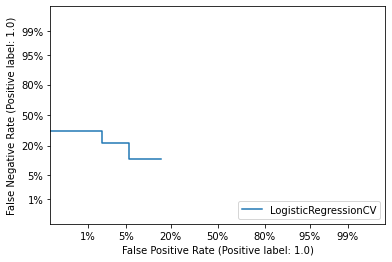

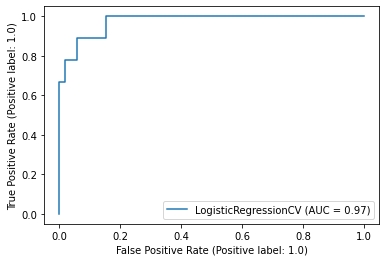

In [64]:
# Use Detection Error Tradeoff (DET) and Receiver Operating Curve (ROC) to further evaluate models
plot_det_curve(clf, X_test_norm, y_test)
plot_roc_curve(clf, X_test_norm, y_test)

<a id="boost"></a>
## Gradient Boosting Model
For the XGBoost model, we will first use error to determine the best model. Once we create confusion matrices based on various thresholds, we can evaludate the recall to compare the results to the regression.

Like the regression, we will try 4 versions of the model:

- Vanilla (no-CV) XGBoost with original distribution
- 5-fold Cross-Validated XGBoost with original distribution
- Vanilla (no-CV) XGBoost with oversampled distribution
- 5-fold Cross-Validated XGBoost with oversampled distribution

In [65]:
# Parameters for XGB model
params = {
     'n_estimators': 1000,
     'learning_rate': 0.07,
     'objective': 'binary:logistic',
     'eval_metric': 'error',
     'nthread': 5,
     'verbosity': 1
    }
xgb_results = []

# Possible combinations of depth and alpha to test
tunes = [(2,1),(2,2),(5,1),(5,2)]

# K-fold stratifications for CV models
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, y_train)
skf1 = StratifiedKFold(n_splits=5)
skf1.get_n_splits(X_o_train, y_o_train)

5

In [66]:
# Vanilla XGB with original distribuion
results_list = []
for depth, alpha in tunes:
    params.update({'max_depth':depth, 'alpha':alpha})
    xgb_dmat = xgb.DMatrix(X_train, label=y_train)
    model = xgb.XGBClassifier(**params, use_label_encoder=False)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='error', verbose=False)
    results = model.evals_result()
    results_list.append(results)

In [67]:
# Compute results of model
tr_err = [sum(results_list[i]['validation_0']['error']) for i in range(len(results_list))]
val_err = [sum(results_list[i]['validation_1']['error']) for i in range(len(results_list))]

tr_res = results_list[tr_err.index(min(tr_err))]['validation_0']['error']
val_res = results_list[val_err.index(min(val_err))]['validation_1']['error']
xgb_results.append((f1_score(y_train, model.predict(X_train)), f1_score(y_test, model.predict(X_test))))

print('Best parameters: max_depth={}, alpha={}'.format(*tunes[tr_err.index(min(tr_err))]))
print(f'Training error: {tr_res[-1]:.5f}\nTesting error: {val_res[-1]:.5f}')

Best parameters: max_depth=5, alpha=1
Training error: 0.00009
Testing error: 0.00053


In [68]:
# XGB with 5-fold cross-validation and original distribution
results_list1 = []
for depth, alpha in tunes:
    params.update({'max_depth':depth, 'alpha':alpha})
    for train_index, val_index in skf.split(X_train, y_train):
        x_tr, x_val = X_train[train_index, :], X_train[val_index, :]
        #print(x_tr.shape)
        y_tr, y_val = y_train[train_index], y_train[val_index]
        xgb_dmat = xgb.DMatrix(x_tr, label=y_tr)
        #print(1)
        model1 = xgb.XGBClassifier(**params, use_label_encoder=False)
        model1.fit(x_tr, y_tr, eval_set=[(x_tr, y_tr), (x_val, y_val)],eval_metric='error', verbose=False)
        results = model1.evals_result()
        results_list1.append(results)

In [69]:
# Compute results of model
tr_err = [sum(results_list1[i]['validation_0']['error']) for i in range(len(results_list1))]
val_err = [sum(results_list1[i]['validation_1']['error']) for i in range(len(results_list1))]

tr_res = results_list1[tr_err.index(min(tr_err))]['validation_0']['error']
val_res = results_list1[val_err.index(min(val_err))]['validation_1']['error']
xgb_results.append((f1_score(y_train, model1.predict(X_train)), f1_score(y_test, model1.predict(X_test))))

print('Best parameters: max_depth={}, alpha={}'.format(*tunes[tr_err.index(min(tr_err)) // 5]))
print(f'Training error: {tr_res[-1]:.5f}\nTesting error: {val_res[-1]:.5f}')

Best parameters: max_depth=5, alpha=1
Training error: 0.00006
Testing error: 0.00044


In [70]:
# Vanilla XGB with oversampled distribuion
results_list2 = []
for depth, alpha in tunes:
    params.update({'max_depth':depth, 'alpha':alpha})
    xgb_dmat = xgb.DMatrix(X_o_train, label=y_o_train)
    model2 = xgb.XGBClassifier(**params, use_label_encoder=False)
    model2.fit(X_o_train, y_o_train, eval_set=[(X_o_train, y_o_train), (X_test, y_test)], eval_metric='error', verbose=False)
    results = model2.evals_result()
    results_list2.append(results)

In [71]:
# Compute results of model
tr_err = [sum(results_list2[i]['validation_0']['error']) for i in range(len(results_list2))]
val_err = [sum(results_list2[i]['validation_1']['error']) for i in range(len(results_list2))]

tr_res = results_list2[tr_err.index(min(tr_err))]['validation_0']['error']
val_res = results_list2[val_err.index(min(val_err))]['validation_1']['error']
xgb_results.append((f1_score(y_o_train, model2.predict(X_o_train)), f1_score(y_test, model2.predict(X_test))))

print('Best parameters: max_depth={}, alpha={}'.format(*tunes[tr_err.index(min(tr_err)) // 5]))
print(f'Training error: {tr_res[-1]:.5f}\nTesting error: {val_res[-1]:.5f}')

Best parameters: max_depth=2, alpha=1
Training error: 0.00004
Testing error: 0.00053


In [72]:
# XGB with 5-fold cross-validation and oversampled distribution
results_list3 = []
for depth, alpha in tunes:
    params.update({'max_depth':depth, 'alpha':alpha})
    for train_index, val_index in skf.split(X_train, y_train):
        x_tr, x_val = X_o_train[train_index, :], X_o_train[val_index, :]
        #print(x_tr.shape)
        y_tr, y_val = y_o_train[train_index], y_o_train[val_index]
        xgb_dmat = xgb.DMatrix(x_tr, label=y_tr)
        #print(1)
        model3 = xgb.XGBClassifier(**params, use_label_encoder=False)
        model3.fit(x_tr, y_tr, eval_set=[(x_tr, y_tr), (x_val, y_val)],eval_metric='error', verbose=False)
        results = model3.evals_result()
        results_list3.append(results)

In [73]:
# Compute results of model
tr_err = [sum(results_list3[i]['validation_0']['error']) for i in range(len(results_list3))]
val_err = [sum(results_list3[i]['validation_1']['error']) for i in range(len(results_list3))]

tr_res = results_list3[tr_err.index(min(tr_err))]['validation_0']['error']
val_res = results_list3[val_err.index(min(val_err))]['validation_1']['error']
xgb_results.append((f1_score(y_o_train, model3.predict(X_o_train)), f1_score(y_test, model3.predict(X_test))))

print('Best parameters: max_depth={}, alpha={}'.format(*tunes[tr_err.index(min(tr_err)) // 5]))
print(f'Training error: {tr_res[-1]:.5f}\nTesting error: {val_res[-1]:.5f}')

Best parameters: max_depth=2, alpha=1
Training error: 0.00000
Testing error: 0.00000


In [74]:
# Determine best performing model parameters
val_results = [x[1] for x in xgb_results]
best_xgb = val_results.index(max(val_results))
f'The best result ({max(val_results):.4f}) was from #{val_results.index(max(val_results))}'

'The best result (0.8000) was from #0'

### Best XGB Model

Again, the use of the oversampled population did not improve the model performance based on the established metric, although in this case it did result in a lower error rate. As error was the metric used to train the model, it may not be entirely justifiable to evaluate it based on a separate metric and reject the model which performed best based on the objective, but the XGB package does not appear to have a f1 score objective available.

In this case, the cross-validation reduced the error and improved the f1 scores, while it did not provide benefit in the regression models.

In [82]:
# Use probability predictions to test thresholds
probs_te = model.predict_proba(X_test)
prob1 = [x[1] for x in probs_te]

# Test thresholds 0.25 - 0.75
y_te_25 = [int(x + 0.25) for x in prob1]
y_te_50 = [int(x + 0.5) for x in prob1]
y_te_75 = [int(x + 0.75) for x in prob1]

# Create confusion matrices
x_conf_mat25 = confusion_matrix(y_test, y_te_25)
x_conf_mat50 = confusion_matrix(y_test, y_te_50)
x_conf_mat75 = confusion_matrix(y_test, y_te_75)

print('confusion matrix with 0.25 threshold \n', x_conf_mat25)
print('confusion matrix with 0.50 threshold \n', x_conf_mat50)
print('confusion matrix with 0.75 threshold \n', x_conf_mat75)

confusion matrix with 0.25 threshold 
 [[5688    0]
 [   5    4]]
confusion matrix with 0.50 threshold 
 [[5688    0]
 [   3    6]]
confusion matrix with 0.75 threshold 
 [[5687    1]
 [   3    6]]


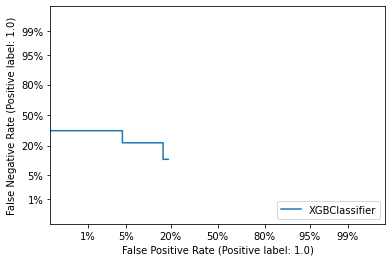

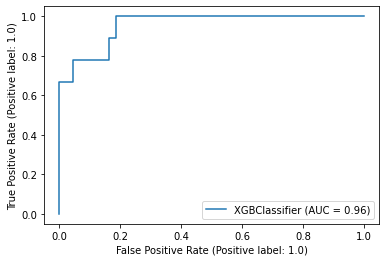

In [83]:
# Use Detection Error Tradeoff (DET) and Receiver Operating Curve (ROC) to further evaluate models
plot_det_curve(model, X_test, y_test)
plot_roc_curve(model, X_test, y_test)

<a id="variable"></a>
## Variable Importance
To analyze variable importance, we will look at the variable coeffients for the logistic regression and the feature importance for the XGB classifier models.

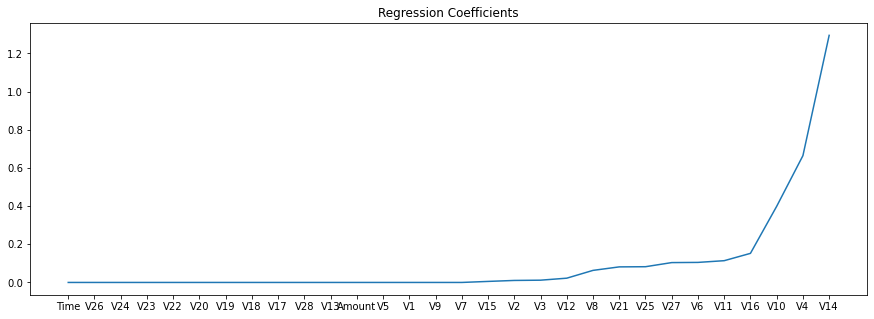

In [84]:
# Regression Features
coef_df = pd.DataFrame(clf2.coef_, columns=df.columns[:-1]).melt().set_index('variable')
coef_df.value = coef_df.value.abs()
plt.figure(figsize=(15,5))
plt.title('Regression Coefficients')
plt.plot(coef_df.sort_values('value'))
plt.show();

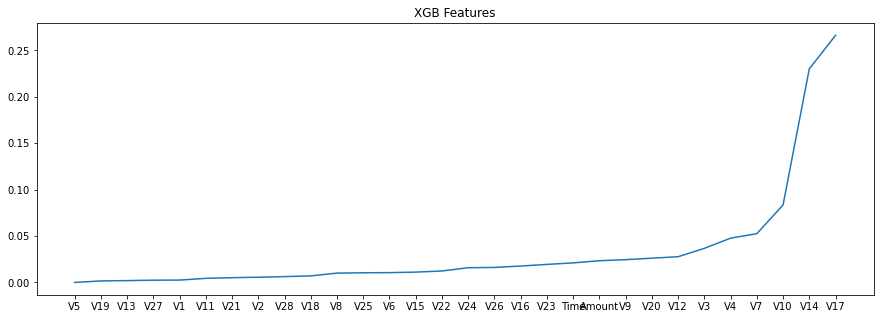

In [85]:
# XGB Features
feature_importance_df = pd.DataFrame.from_dict(dict(zip(df.columns, model1.feature_importances_)), orient='index')
plt.figure(figsize=(15,5))
plt.title('XGB Features')
plt.plot(feature_importance_df.sort_values(0))
plt.show();

### *Analysis*
Based on the charts above, both models identified similar features (V10 and V14 as most important), but the regression model gives more weight to less important features compared to the XGBoost.

<a id="compare"></a>
## Model Comparison

In [79]:
# Compare model f1_score results
print(f'''Best logistic regression metrics: {model_results[best_reg]}
Best XGB metrics: {xgb_results[best_xgb]}''')

# Compare model accuracy
reg_acc = accuracy_score(y_test, clf.predict(X_test))
xgb_acc = accuracy_score(y_test, model1.predict(X_test))
print()
print(f'''Best logistic regression accuracy: {reg_acc}
Best XGB accuracy: {xgb_acc}''')

Best logistic regression metrics: (0.7741935483870968, 0.7142857142857143)
Best XGB metrics: (0.8709677419354839, 0.8)

Best logistic regression accuracy: 0.9984202211690363
Best XGB accuracy: 0.9994734070563455


In [87]:
# Pairs of matrices at thresholds to compute costs
conf_mtx = [(conf_mat25, x_conf_mat25), (conf_mat50, x_conf_mat50), (conf_mat75, x_conf_mat75)]

# Costs for each model at each threshold
for reg_mx, xgb_mx in conf_mtx:
    reg_cost = reg_mx[0][1] * 25 + reg_mx[1][0] * 4000
    xgb_cost = xgb_mx[0][1] * 25 + xgb_mx[1][0] * 4000
    print(f'Cost for log reg: {reg_cost}, xgb: {xgb_cost}, {reg_cost / xgb_cost:.2%}')

Cost for log reg: 24000, xgb: 20000, 120.00%
Cost for log reg: 16000, xgb: 12000, 133.33%
Cost for log reg: 12025, xgb: 12025, 100.00%


### *Analysis*
The models performed almost identically on the testing dataset, although the XGB model had much better metrics on the training data. As the regression model gives more weight to a broader number of variables, it is likely to be more generalizable to new data that may not exactly match historical patterns.

In [88]:
!jupyter nbconvert --to html --template full *.ipynb

[NbConvertApp] Converting notebook Project_3_Conan.ipynb to html
[NbConvertApp] Writing 477601 bytes to Project_3_Conan.html
